In [1]:
# Setting the environment variables

In [2]:
import os
import sys
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON_OPTS"]="notebook --no-browser"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] + "/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] + "/pyspark.zip")

# Ecommerce Churn Assignment

The aim of the assignment is to build a model that predicts whether a person purchases an item after it has been added to the cart or not. Being a classification problem, you are expected to use your understanding of all the three models covered till now. You must select the most robust model and provide a solution that predicts the churn in the most suitable manner. 

For this assignment, you are provided the data associated with an e-commerce company for the month of October 2019. Your task is to first analyse the data, and then perform multiple steps towards the model building process.

The broad tasks are:
- Data Exploration
- Feature Engineering
- Model Selection
- Model Inference

### Data description

The dataset stores the information of a customer session on the e-commerce platform. It records the activity and the associated parameters with it.

- **event_time**: Date and time when user accesses the platform
- **event_type**: Action performed by the customer
            - View
            - Cart
            - Purchase
            - Remove from cart
- **product_id**: Unique number to identify the product in the event
- **category_id**: Unique number to identify the category of the product
- **category_code**: Stores primary and secondary categories of the product
- **brand**: Brand associated with the product
- **price**: Price of the product
- **user_id**: Unique ID for a customer
- **user_session**: Session ID for a user


### Initialising the SparkSession

The dataset provided is 5 GBs in size. Therefore, it is expected that you increase the driver memory to a greater number. You can refer to notebook 1 for the steps involved here.

In [3]:
# Spark environment
from pyspark import SparkConf
from pyspark.sql import SparkSession

# initialising the session with 14 GB driver memory
MAX_MEMORY = "14G"

spark = SparkSession \
    .builder \
    .appName("demo") \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config("spark.memory.offHeap.enabled","true") \
    .config("spark.memory.offHeap.size","10g") \
    .getOrCreate()

spark

In [4]:
# Spark session with 14 GB driver memory
spark.sparkContext.getConf().get('spark.driver.memory')

'14G'

In [5]:
# Loading the clean data
df = spark.read.parquet("final_df/final_df.parquet")

In [6]:
df = df.fillna('others')

In [7]:
df_org = df

In [8]:
dfp = df_org.toPandas()
dfp

event_type product_id    brand    price    user_id     category  \
0             cart    1004835  samsung   230.89  532230882  electronics   
1         purchase    1801690  samsung   368.04  555467805  electronics   
2         purchase    1003306    apple   587.56  547952735  electronics   
3         purchase    1004870  samsung   286.86  555148121  electronics   
4         purchase   26402505   others   950.73  555463488       others   
...            ...        ...      ...      ...        ...          ...   
1245280   purchase   10400392   others    25.71  566267483         kids   
1245281   purchase    1004566   huawei   164.84  541238676  electronics   
1245282       cart    1005115    apple   949.47  566272904  electronics   
1245283   purchase    1304409    apple  1402.87  562780507    computers   
1245284   purchase    1004767  samsung   242.63  551781196  electronics   

        secondary_category   weekday hour_bucket  is_purchased  
0               smartphone   Tuesday       Night             0  
1                    video   Tuesday       Night             1  
2               smartphone   Tuesday       Night             1  
3               smartphone   Tuesday       Night             1  
4                   others   Tuesday       Night             1  
...                    ...       ...         ...           ...  
1245280               toys  Thursday       Night             1  
1245281         smartphone  Thursday       Night             1  
1245282         smartphone  Thursday       Night             0  
1245283           notebook  Thursday       Night             1  
1245284         smartphone  Thursday       Night             1  

[1245285 rows x 10 columns]

In [9]:
dfp.isna().sum()

event_type            0
product_id            0
brand                 0
price                 0
user_id               0
category              0
secondary_category    0
weekday               0
hour_bucket           0
is_purchased          0
dtype: int64

<hr>

## Task 3: Model Selection
3 models for classification:	
- Logistic Regression
- Decision Tree
- Random Forest

### Model 2: Decision Trees

In [10]:
# Check if only the required columns are present to build the model
# If not, drop the redundant columns

In [11]:
dfp.product_id.nunique()

44157

In [12]:
#drop product_id since it can't be encoded due high number of categories
df = df.drop('product_id')

In [13]:
#drop user_id since it is an identifier and it is unnecessary
df = df.drop("user_id")

In [14]:
#drop event_type since it was used to generate target variable is_purchased
df = df.drop('event_type')

In [15]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler

In [16]:
stringCols = ['brand','category','secondary_category','weekday','hour_bucket']
for c in stringCols:
    outCol = c + '_ix'
    si = StringIndexer(inputCol=c, outputCol=outCol)
    df = si.fit(df).transform(df)

In [17]:
df.printSchema()

root
 |-- brand: string (nullable = false)
 |-- price: string (nullable = false)
 |-- category: string (nullable = false)
 |-- secondary_category: string (nullable = false)
 |-- weekday: string (nullable = false)
 |-- hour_bucket: string (nullable = false)
 |-- is_purchased: integer (nullable = true)
 |-- brand_ix: double (nullable = false)
 |-- category_ix: double (nullable = false)
 |-- secondary_category_ix: double (nullable = false)
 |-- weekday_ix: double (nullable = false)
 |-- hour_bucket_ix: double (nullable = false)



In [18]:
df.show(3)

+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+
|  brand| price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|
+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+
|samsung|230.89|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|
|samsung|368.04|electronics|             video|Tuesday|      Night|           1|     1.0|        0.0|                  4.0|       1.0|           1.0|
|  apple|587.56|electronics|        smartphone|Tuesday|      Night|           1|     2.0|        0.0|                  0.0|       1.0|           1.0|
+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------

In [19]:
categoricalCols = [c+'_ix' for c in stringCols]
ohe = OneHotEncoderEstimator(inputCols=categoricalCols, outputCols=[c+'_Enc' for c in categoricalCols])
enc_model = ohe.fit(df)
df = enc_model.transform(df)

In [20]:
df.printSchema()

root
 |-- brand: string (nullable = false)
 |-- price: string (nullable = false)
 |-- category: string (nullable = false)
 |-- secondary_category: string (nullable = false)
 |-- weekday: string (nullable = false)
 |-- hour_bucket: string (nullable = false)
 |-- is_purchased: integer (nullable = true)
 |-- brand_ix: double (nullable = false)
 |-- category_ix: double (nullable = false)
 |-- secondary_category_ix: double (nullable = false)
 |-- weekday_ix: double (nullable = false)
 |-- hour_bucket_ix: double (nullable = false)
 |-- brand_ix_Enc: vector (nullable = true)
 |-- secondary_category_ix_Enc: vector (nullable = true)
 |-- category_ix_Enc: vector (nullable = true)
 |-- hour_bucket_ix_Enc: vector (nullable = true)
 |-- weekday_ix_Enc: vector (nullable = true)



In [21]:
df.show(3)

+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|  brand| price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|  brand_ix_Enc|secondary_category_ix_Enc|category_ix_Enc|hour_bucket_ix_Enc|weekday_ix_Enc|
+-------+------+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|samsung|230.89|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|(20,[1],[1.0])|           (56,[0],[1.0])| (13,[0],[1.0])|     (2,[1],[1.0])| (6,[1],[1.0])|
|samsung|368.04|electronics|        

In [22]:
from pyspark.sql.types import IntegerType
df = df.withColumn("price", df["price"].cast(IntegerType()))

In [23]:
df.show(3)

+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|  brand|price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|  brand_ix_Enc|secondary_category_ix_Enc|category_ix_Enc|hour_bucket_ix_Enc|weekday_ix_Enc|
+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+
|samsung|  230|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|(20,[1],[1.0])|           (56,[0],[1.0])| (13,[0],[1.0])|     (2,[1],[1.0])| (6,[1],[1.0])|
|samsung|  368|electronics|             

In [24]:
trainCols = [c+'_Enc' for c in categoricalCols] + ['price']
assembler = VectorAssembler(inputCols=trainCols, outputCol='features_')
df = assembler.transform(df)
df.show(3)

+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+--------------------+
|  brand|price|   category|secondary_category|weekday|hour_bucket|is_purchased|brand_ix|category_ix|secondary_category_ix|weekday_ix|hour_bucket_ix|  brand_ix_Enc|secondary_category_ix_Enc|category_ix_Enc|hour_bucket_ix_Enc|weekday_ix_Enc|           features_|
+-------+-----+-----------+------------------+-------+-----------+------------+--------+-----------+---------------------+----------+--------------+--------------+-------------------------+---------------+------------------+--------------+--------------------+
|samsung|  230|electronics|        smartphone|Tuesday|      Night|           0|     1.0|        0.0|                  0.0|       1.0|           1.0|(20,[1],[1.0])|           (56,[0],[1.0])| (13,[0],[1.0])|     (2,[1],

In [25]:
df = df.drop(*stringCols)
df = df.drop(*[c+'_ix' for c in stringCols])
df = df.drop(*[c+'_Enc' for c in categoricalCols])
df = df.drop('price')

In [26]:
df.printSchema()

root
 |-- is_purchased: integer (nullable = true)
 |-- features_: vector (nullable = true)



In [27]:
df.show(3)

+------------+--------------------+
|is_purchased|           features_|
+------------+--------------------+
|           0|(98,[1,20,33,90,9...|
|           1|(98,[1,20,37,90,9...|
|           1|(98,[2,20,33,90,9...|
+------------+--------------------+
only showing top 3 rows



In [28]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features_', outputCol='features')
scaler_m = scaler.fit(df)
df = scaler_m.transform(df)
df.show(3)

# from pyspark.ml.feature import MinMaxScaler
# scaler = MinMaxScaler(min=0, max=1, inputCol='features_', outputCol='features')
# scaler_model = scaler.fit(df)
# df = scaler_model.transform(df)
# df.show(3)

+------------+--------------------+--------------------+
|is_purchased|           features_|            features|
+------------+--------------------+--------------------+
|           0|(98,[1,20,33,90,9...|(98,[1,20,33,90,9...|
|           1|(98,[1,20,37,90,9...|(98,[1,20,37,90,9...|
|           1|(98,[2,20,33,90,9...|(98,[2,20,33,90,9...|
+------------+--------------------+--------------------+
only showing top 3 rows



In [29]:
df = df.drop('features_')

In [30]:
dfp.is_purchased.value_counts()   #approximately same no of purchases as no of additions to cart

# appx 50% conversion rate from cart to purchase

# no need for stratified sampling for train test split as dataset is fairly balanced

1    658740
0    586545
Name: is_purchased, dtype: int64

#### Train-test split

In [31]:
# Splitting the data into train and test (Remember you are expected to compare the model later)
train, test = df.randomSplit([0.8,0.2], seed=2022)

In [32]:
train.show(2)

+------------+--------------------+
|is_purchased|            features|
+------------+--------------------+
|           0|(98,[0,20,33,89,9...|
|           0|(98,[0,20,33,89,9...|
+------------+--------------------+
only showing top 2 rows



In [33]:
test.show(2)

+------------+--------------------+
|is_purchased|            features|
+------------+--------------------+
|           0|(98,[0,20,33,89,9...|
|           0|(98,[0,20,33,89,9...|
+------------+--------------------+
only showing top 2 rows



In [34]:
# Number of rows in train and test data
print(train.count())
print(test.count())

996456
248829


#### Model Fitting

In [35]:
# Building and Fitting the model
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol="features", labelCol="is_purchased")
#Fit the training data
model = dt.fit(train)

#Transform the test data as follows:
predictions = model.transform(test)

#View the resultant dataframe to analyse better as follows:
predictions.select("prediction", "is_purchased", "features").show(5)

+----------+------------+--------------------+
|prediction|is_purchased|            features|
+----------+------------+--------------------+
|       1.0|           0|(98,[0,20,33,89,9...|
|       1.0|           0|(98,[0,20,33,89,9...|
|       1.0|           0|(98,[0,20,33,89,9...|
|       1.0|           0|(98,[0,20,33,89,9...|
|       1.0|           0|(98,[0,20,33,89,9...|
+----------+------------+--------------------+
only showing top 5 rows



In [36]:
# Evaluating the model

#Load the required libraries as follows:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Run the evaluator function as follows:
evaluator=BinaryClassificationEvaluator(labelCol="is_purchased",metricName="areaUnderROC")

#View the accuracy as follows:
accuracy = evaluator.evaluate(predictions)
accuracy

0.4102141188713885

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

pred_ = predictions.select('is_purchased','prediction').toPandas()

# target_names = ['0','1']

print("Confusion Matrix: ")
print(confusion_matrix(pred_.is_purchased, pred_.prediction,),"\n\n")
      
print(classification_report(pred_.is_purchased, pred_.prediction,)) #target_names=target_names))

Confusion Matrix: 
[[94306 22963]
 [81496 50064]] 


              precision    recall  f1-score   support

           0       0.54      0.80      0.64    117269
           1       0.69      0.38      0.49    131560

    accuracy                           0.58    248829
   macro avg       0.61      0.59      0.57    248829
weighted avg       0.62      0.58      0.56    248829



#### Model Analysis

Required Steps:
- Fit on test data
- Performance analysis
    - Appropriate Metric with reasoning
    - Threshold selection

In [38]:
# Get Feature Importance

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [39]:
ExtractFeatureImp(model.featureImportances, predictions, 'features')

KeyError: 'ml_attr'

In [40]:
print(model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f8288232cb2) of depth 5 with 19 nodes
  If (feature 0 <= 1.123859215531387)
   If (feature 10 <= 5.406084055125197)
    If (feature 7 <= 4.853368012108271)
     If (feature 19 <= 11.172678004513743)
      If (feature 27 <= 6.4768825493610755)
       Predict: 0.0
      Else (feature 27 > 6.4768825493610755)
       Predict: 1.0
     Else (feature 19 > 11.172678004513743)
      Predict: 1.0
    Else (feature 7 > 4.853368012108271)
     Predict: 1.0
   Else (feature 10 > 5.406084055125197)
    Predict: 1.0
  Else (feature 0 > 1.123859215531387)
   If (feature 21 <= 1.2954958377723877)
    If (feature 27 <= 6.4768825493610755)
     Predict: 1.0
    Else (feature 27 > 6.4768825493610755)
     If (feature 72 <= 66.21973143221904)
      Predict: 1.0
     Else (feature 72 > 66.21973143221904)
      If (feature 97 <= 0.08356145542538557)
       Predict: 0.0
      Else (feature 97 > 0.08356145542538557)
       Predict: 1.0
   Else (feat

#### Updated model, if any
Repeat the steps 

In [41]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [5, 10, 25]) \
    .build()


crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(labelCol="is_purchased",metricName="areaUnderROC"),
                          numFolds=5)  

cvModel = crossval.fit(train)

prediction = cvModel.transform(test)
prediction.show(5)

+------------+--------------------+-------------+--------------------+----------+
|is_purchased|            features|rawPrediction|         probability|prediction|
+------------+--------------------+-------------+--------------------+----------+
|           0|(98,[0,20,33,89,9...|    [7.0,9.0]|     [0.4375,0.5625]|       1.0|
|           0|(98,[0,20,33,89,9...|    [9.0,7.0]|     [0.5625,0.4375]|       0.0|
|           0|(98,[0,20,33,89,9...|    [9.0,7.0]|     [0.5625,0.4375]|       0.0|
|           0|(98,[0,20,33,89,9...|    [9.0,7.0]|     [0.5625,0.4375]|       0.0|
|           0|(98,[0,20,33,89,9...|  [20.0,55.0]|[0.26666666666666...|       1.0|
+------------+--------------------+-------------+--------------------+----------+
only showing top 5 rows



In [42]:
pred_ = prediction.select('is_purchased','prediction').toPandas()

# target_names = ['0','1']

print("Confusion Matrix: ")
print(confusion_matrix(pred_.is_purchased, pred_.prediction,),"\n\n")
      
print(classification_report(pred_.is_purchased, pred_.prediction,)) #target_names=target_names))

Confusion Matrix: 
[[86282 30987]
 [71410 60150]] 


              precision    recall  f1-score   support

           0       0.55      0.74      0.63    117269
           1       0.66      0.46      0.54    131560

    accuracy                           0.59    248829
   macro avg       0.60      0.60      0.58    248829
weighted avg       0.61      0.59      0.58    248829



In [43]:
import pandas as pd

dfp.drop(['event_type','product_id','user_id'],axis=1,inplace=True)

dfp.fillna('others',inplace=True)

dfp_ = pd.get_dummies(data=dfp, columns=['brand', 'category', 'secondary_category', 'weekday','hour_bucket'],drop_first=True)

dfp[['brand','category','secondary_category','weekday','hour_bucket']] = dfp[['brand', 'category', 'secondary_category', 
                                                                            'weekday','hour_bucket']].astype('category')

dfp['price'] = dfp['price'].astype(float)

cats = ['brand','category','secondary_category','weekday','hour_bucket']
for x in cats:
    dfp[x]=dfp[x].cat.codes

dfp

brand    price  category  secondary_category  weekday  hour_bucket  \
0           18   230.89         7                  40        5            2   
1           18   368.04         7                  55        5            2   
2            1   587.56         7                  40        5            2   
3           18   286.86         7                  40        5            2   
4           14   950.73        11                  29        5            2   
...        ...      ...       ...                 ...      ...          ...   
1245280     14    25.71         9                  48        4            2   
1245281      8   164.84         7                  40        4            2   
1245282      1   949.47         7                  40        4            2   
1245283      1  1402.87         4                  28        4            2   
1245284     18   242.63         7                  40        4            2   

         is_purchased  
0                   0  
1                   1  
2                   1  
3                   1  
4                   1  
...               ...  
1245280             1  
1245281             1  
1245282             0  
1245283             1  
1245284             1  

[1245285 rows x 7 columns]

Feature: 0, Score: 0.11047
Feature: 1, Score: 0.48960
Feature: 2, Score: 0.19868
Feature: 3, Score: 0.04048
Feature: 4, Score: 0.10639
Feature: 5, Score: 0.05438


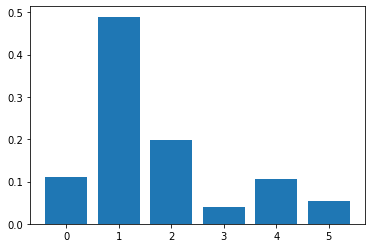

In [44]:
# decision tree for feature importance on a classification problem
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot
# define dataset
X, y = dfp.drop('is_purchased',axis=1),dfp['is_purchased']
# define the model
modeldt = DecisionTreeClassifier()
# fit the model
modeldt.fit(X, y)
# get importance
importance = modeldt.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [45]:
X.columns

Index(['brand', 'price', 'category', 'secondary_category', 'weekday',
       'hour_bucket'],
      dtype='object')

### Price seems to be most important feature from using Decision Tree